In [357]:
import numpy as np
import pandas as pd
import sys
sys.path.append('/root/persistence_data/TechfinDataRAD')

from FactorAutoBuild import *
from sklearn import linear_model as sklm
from collections import defaultdict
import math
import heapq

from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, WLS
import statsmodels.api as sm
import statsmodels.stats.stattools as smt
from statsmodels.tsa import stattools as sts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
daily_data = pd.read_csv('arranged_data_20140102_20211029.csv', index_col=0, header=[0,1])

key_ref = set([key[0] for key in daily_data.columns])
# d = {key:daily_data.loc[:,(key, slice(None))].T.reset_index(level=0, drop=True) for key in k}
locals().update({key:daily_data.loc[:,(key, slice(None))].T.reset_index(level=0, drop=True) for key in key_ref})



#.set_index(['trade_date', 'stock_code']).sort_index()

'''
此处对于pe，ps的nan处理是做线性插值，也可以试一下因子回归的方式，即使用更复杂的生成模型
具体处理见DataDealer.ipynb

变量名见key_ref
'''

'\n此处对于pe，ps的nan处理是做线性插值，也可以试一下因子回归的方式，即使用更复杂的生成模型\n具体处理见DataDealer.ipynb\n\n变量名见key_ref\n'

In [3]:
# k = set([key[0] for key in daily_data.columns])
# d = {key:daily_data.loc[:,(key, slice(None))].T.reset_index(level=0, drop=True) for key in k}
# locals().update(d)
# daily_data
key_ref

{'circulating_market_cap',
 'close',
 'high',
 'indus_index',
 'low',
 'market_cap',
 'open',
 'pb_ratio',
 'pe_ratio',
 'ps_ratio',
 'return_adj',
 'turnover_ratio'}

In [4]:
ep_ratio = 1/pe_ratio
bp_ratio = 1/pb_ratio

股票池
1.全市场，
2.扔掉30%小市值股票（壳价值污染严重的部分 shell value），是否可以有效降低对与壳价值的暴露， 壳价值如何计算？

构造的portfolio作比较。哪种比较好？

或是利用2来作某些因子回归，而股票池依旧选择1
或者反过来？

寻找尽量简单且能够解释超额收益的模型是最终的目标。

寻找可以解释别人的模型解释不了的异象的因子
寻找可以覆盖别人的因子的因子
提高回归的r^2是努力方向


In [5]:
# 极值处理
# 可以有效的改善数据分布
# 降低厚尾，降低偏度
# 对于离群值的额外处理可以使最终的zscore可比性更强

def csMAD(factor, r=3):
    '''
    横截面mad标准化
    拉回离群值，
    这种方法对离群值不敏感。
    
    注意：
    会失去离群值的排序信息。
    可以不拉回标准位置，而是拉到标准位置附近的区间内，并保持原有的排序信息。
    '''
    mid = factor.median(axis=1)
    mad = factor.sub(mid, axis=0).apply(np.abs).median(axis=1)
    up = mid+r*mad
    down = mid-r*mad
    
    factor = factor.where(factor.lt(up,axis=0), up, axis=0).where(factor.gt(down,axis=0), down, axis=0)
    
    return factor


def csFixPct(factor, pct=0.015):
    '''
    固定比例调整,拉回离群值
    很少比例的离群值决定了拉回界限！
    '''
    up = factor.quantile(1-pct, axis=1)
    down = factor.quantile(pct, axis=1)
    
    factor = factor.where(factor.lt(up,axis=0), up, axis=0).where(factor.gt(down,axis=0), down, axis=0)
    return factor


def BarraEUE3(factor, pad=0.5, r=3):
    '''
    将超出3std的数据拉回到[3,3+pad]范围，保留原有的数据排序
    可以有效改善厚尾和偏度
    '''
    
    factor = standardize(factor)
    
    spos = (pad/(factor.max(axis=1)-r)).apply(lambda x: max(0, min(1,x)))
    sneg = (pad/(-factor.min(axis=1)-r)).apply(lambda x: max(0, min(1,x)))
    
    factorpos = factor.mul(spos, axis=0).add(r*(1-spos), axis=0)
    factorneg = factor.mul(sneg, axis=0).sub(r*(1-sneg), axis=0)
    
    factor = factor.where(factor<=r, factorpos).where(factor>=-r, factorneg)
    return factor

def boxplot_adj(factor):
    '''
    原始的boxplot对数据具有对称性假设
    
    这里实现的是偏度调整的boxplot
    Hubert & Vandervieren(2007)
    
    https://blog.csdn.net/Eaton18/article/details/106484481/
    '''
    
    Q1 = factor.quantile(0.25, axis=1)
    Q3 = factor.quantile(0.75, axis=1)
    
    IQR = Q3-Q1
    
    mc = smt.medcouple(factor, axis=1)
    # 分布偏度度量，[-1,1], >0右偏，
    
    Lpos = Q1-1.5*np.exp(-3.5*mc)*IQR
    Lneg = Q1-1.5*np.exp(-4*mc)*IQR
    
    Upos = Q3+1.5*np.exp(4*mc)*IQR
    Uneg = Q3+1.5*np.exp(3.5*mc)*IQR
    
    down = Lpos.where(mc>=0, Lneg)
    up = Upos.where(mc>=0, Uneg)
    
    factor = factor.where(factor.lt(up,axis=0), up, axis=0).where(factor.gt(down,axis=0), down, axis=0)
    return factor


# csMAD(meanTurnover, 2)
    

In [6]:
# 标准化 z-score

def standardize(factor):
    if len(factor.shape)==2:
        mu = factor.mean(axis=1)
        sigma = factor.std(axis=1)
        factor = factor.sub(mu, axis=0).div(sigma,axis=0)
    elif len(factor.shape)==1:
        factor = (factor-factor.mean())/factor.std()
        
    else:
        raise Exception('can only standardize 1-d or 2-d data')
    
    return factor

In [269]:
'''
趋势因子descriptor
close 等价于 cap
'''
def Tmovern(close, speriods, lperiods):
    t = (close.rolling(speriods).mean())/(close.rolling(lperiods).mean())
    t = standardize(csMAD(t,3))
    return t

T120 = Tmovern(close, 5, 120)
T240 = Tmovern(close, 5, 240)

# Factor_Trend = 0.5*T120.add(0.5*T240)
Factor_Trend = 0.5*T120+0.5*T240
'''
计算T120和T240前置的nan数量不同，.add选择or， +选择and
'''

Factor_Trend = standardize(boxplot_adj(Factor_Trend))


In [278]:
'''
流动性因子
market=市值加权均值
'''

def marketFac(market_cap, data):
    '''
    计算市值加权的data值,
    data数据格式需要和market_cap相同，
    Series或DataFrame
    返回值为n*1时序序列
    '''
    
    if market_cap.shape!=data.shape:
        raise Exception('market_cap and data should have same structure')
    # if key not in data.columns:
    #     raise Exception('key is not a index of stocks, no way to get a market ts')
    market_cap = market_cap.where(data.notna()) # 根据data选择权重
    if len(data.shape)==2:
        # print('DataFrame calculation')
        mfac = (market_cap.div(market_cap.sum(axis=1),axis=0)*data).sum(axis=1)
    elif len(data.shape)==1:
        # print('Series calculation')
        mfac = (market_cap/market_cap.sum()*data).sum()
    
    return mfac


def fac_tMean(data, periods, W=None, halflife=None):
    '''
    返回值为dataframe， 列为stock， 行为date
    等权平均

    实验方向：加权
    直接传入加权矩阵或者通过设置半衰期的方式
    '''
    if (W is None) and (halflife is None):
        return data.rolling(periods).mean()
    elif W is None:
        weight = (2*halflife-1)/(2*halflife)
        W = np.diag([weight**(periods-i) for i in range(periods)])
        return data.rolling(periods).apply(lambda x: x.values.T.dot(W.dot(x.values)))
    else:
        if W.shape[0]!=periods:
            raise Exception(f'Weight matrix is illegal!\n Need a {periods} dimensional matrix but W is {W.shape[0]} dimension')
        else:
            return data.rolling(periods).apply(lambda x: x.values.T*W*x.values)


def BetaMS(market, stocks, W=None, intercept=False):
    
    if intercept:
        lr = sm.OLS(stocks, sm.add_constant(market), missing='drop')
        return lr.fit().params.iloc[1]
    else:
        lr = sm.OLS(stocks, market, missing='drop')
        
        return lr.fit().params.iloc[0]

def BetaMSMatrix(market, stocks, W=None):
    '''
    不做回归，解析表达式矩阵计算
    等权回归，并没有做近期加权的操作，
    
    20211119 加权回归
    近期更重的权重 会带来更加敏锐的反应。
    时序回归求beta

    加入截距项，个股beta变为beta+alpha/MTO_weighted
    '''
    beta = (stocks.mul(market,axis=0)).sum(axis=0)/((market**2).sum())
    return beta


def LqdBeta(turnover_market, turnover_stock, periods, logi=False, intercept=True):
    if logi:
        turnover_market = turnover_market.apply(np.log)
        turnover_stock = turnover_stock.apply(np.log)
    
    # betas_no_intercept = turnover_stock.rolling(periods, min_periods=periods).apply(lambda x:  BetaMS(turnover_market.loc[x.index], x, intercept=False))
    # betas = [[LinearRegression().fit(turnover_market[i:i+periods,:], turnover_stock[[stock]].iloc[i:i+periods,:]).coef_ for stock in turnover_stock.columns] for i in range(turnover_stock.shape[0]-periods)]
    # betas = pd.DataFrame(betas, columns=turnover_stock.columns, index=turnover_stock.index[periods:])
    betas = turnover_stock.rolling(periods, min_periods=periods).apply(lambda x: BetaMS(turnover_market.loc[x.index], x, intercept=intercept))
    return betas



# lgbeta = LqdBeta(marketTurnover, data.turnover_ratio, 20)
   


In [268]:
marketRet = marketFac(market_cap, return_adj) # 市场收益
marketTurnover = marketFac(market_cap, turnover_ratio) # 市场换手率


In [279]:
meanTurnover = standardize(csMAD(fac_tMean(turnover_ratio, periods=252, halflife=63),3))
lgTObeta= LqdBeta(marketTurnover, turnover_ratio, 502, True, True)

In [280]:
RetBeta = LqdBeta(marketRet, return_adj, 252, )

In [281]:
RetBeta

stock_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,688687.SH,688689.SH,688696.SH,688698.SH,688699.SH,688777.SH,688788.SH,688819.SH,688981.SH,689009.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,0.985611,0.524557,0.637188,0.527079,0.438247,1.349690,0.159764,0.817616,1.251540,0.510243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.552180,NaN
2021-10-26,0.985100,0.532535,0.647667,0.528473,0.436760,1.337983,0.150685,0.819579,1.251143,0.510951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.553665,NaN
2021-10-27,0.984513,0.530017,0.671414,0.508962,0.440471,1.334238,0.104033,0.807828,1.263618,0.505054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.553056,NaN


In [341]:
'''
Beta
1. 市场基准选择（市值加权平均）

2. 按照行业分类，求行业的beta作为行业内个股的先验beta
或者 按照某种特征对股票作分类，求每一类的beta，作为这个类内个股的先验beta
这个特征应该有什么特点呢？（描述两只股票的相似性应该是最重要的）
TIPS. 分类也可以多层次，每次递进进行bayes压缩，最大化剔除偶然因素。
例如，一级行业作为二级行业的先验，压缩后的二级行业作为个股先验，压缩系数指数增长，复杂度指数增长。

3. 先验beta=每组的平均beta（市值加权？）
4. 利用先验beta对每只股票的beta作调整，调整权重如何选取？
'''

def BayesShrinkage(market_cap, stocks_beta, indus_index, q=1, groups=10):
    '''
    https://www.zhihu.com/question/266917275
    stocks_beta
    全市场的市值加权均值beta(近似为1)作为先验
    行业分组作为先验beta
    
    后续方向：市值分组
    
    q 经验压缩系数，q越大，越倾向于先验值
    '''
    # beta_global = stocks_beta.groupby('trade_date').apply(lambda x: marketFac(market_cap.loc[x.index, :], x))
    
    def indusBeta(market_cap, stocks_beta, indus_index):
        industry = list(set(indus_index.iloc[-1,:]))
        res = defaultdict(list)
        for date in market_cap.index:
            if stocks_beta.loc[date, :].isna().all():
                for indus in industry:
                    res[indus].append(np.nan)
                continue
                    
            for indus in industry:
                res[indus].append(marketFac(market_cap.loc[date,:], stocks_beta.loc[date,:].where(indus_index.loc[date,:]==indus)))
                                  
        return pd.DataFrame(res, index=market_cap.index)     
            
    
    indus_beta = indusBeta(market_cap, stocks_beta, indus_index)
    beta_global = indus_index.apply(lambda x: x.map(dict(indus_beta.loc[x.name,:])), axis=1)
    
    
    def getcoef(stocks_beta, beta_global, q=q):
        beta_diff = stocks_beta.sub(beta_global, axis=0)
        nu = q*beta_diff.abs()/((q*beta_diff.abs()).add((beta_diff**2).mean(axis=1).apply(np.sqrt), axis=0))
        return nu
    
    nu = getcoef(stocks_beta, beta_global,q)
    beta_shrink = ((1-nu)*stocks_beta).add(nu*beta_global, axis=0)
    
    return beta_shrink
    

In [342]:
shBeta = BayesShrinkage(market_cap, RetBeta, indus_index)

In [344]:
RetBeta

stock_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,688687.SH,688689.SH,688696.SH,688698.SH,688699.SH,688777.SH,688788.SH,688819.SH,688981.SH,689009.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,0.985611,0.524557,0.637188,0.527079,0.438247,1.349690,0.159764,0.817616,1.251540,0.510243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.552180,NaN
2021-10-26,0.985100,0.532535,0.647667,0.528473,0.436760,1.337983,0.150685,0.819579,1.251143,0.510951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.553665,NaN
2021-10-27,0.984513,0.530017,0.671414,0.508962,0.440471,1.334238,0.104033,0.807828,1.263618,0.505054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.553056,NaN


In [343]:
shBeta

stock_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,688687.SH,688689.SH,688696.SH,688698.SH,688699.SH,688777.SH,688788.SH,688819.SH,688981.SH,689009.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,0.656515,0.522066,0.814572,0.524220,0.827856,1.051113,0.360492,0.676084,1.195178,0.509384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.846746,NaN
2021-10-26,0.657791,0.529580,0.818800,0.526109,0.828305,1.054698,0.359395,0.679936,1.195387,0.510410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.845367,NaN
2021-10-27,0.657526,0.527326,0.826393,0.508501,0.831388,1.056984,0.348401,0.675731,1.209333,0.504808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.845154,NaN


In [360]:
'''
波动率因子
'''

def MaMaxMinRett(return_adj, periods=21, chosen=6):
    
    maxr = return_adj.rolling(periods, min_periods=periods).apply(lambda x: np.mean(heapq.nlargest(chosen, x)))
    minr = return_adj.rolling(periods, min_periods=periods).apply(lambda x: np.mean(heapq.nsmallest(chosen, x)))
    # 两遍排序优化
    
    minr = standardize(csMAD(minr))
    maxr = standardize(csMAD(maxr))
    
    return maxr, minr


def stdvol(close, periods):
    '''
    年化波动率
    '''
    vol = close.rolling(periods).std()*math.sqrt(252/periods)
    vol = standardize(csMAD(vol))
    return vol

def spread(close, periods):
    s = close.rolling(periods).apply(lambda x: x.max()/x.min()-1)
    s = standardize(csMAD(s))
    return s

def FF3Trait(return_adj, market_cap, ep_ratio, intercept=True, periods=252, q=6):
    '''
    periods: 回归周期
    q: 自相关Newey-West调整参数
    '''
    
    '''
    计算FF3因子的特质波动率
    每只股票对FF3因子做回归，得到的R^2可以用来求解未被解释的部分，即为特质波动率
    sqrt(1-R^2)*std(stock)
    或者利用截距项的t统计量
    
    回归中加入intercept作为无风险收益率与FF3异象
    保证了估计的无偏
    
    回归在时序上，所以stock的收益自相关会影响对于std(stock)的估计，
    
    单只股票FF3残差序列，时序相关性验证：
    1. 每个时刻，使用前peirods周期时间数据回归，得到残差序列作为当前时刻残差序列
    2. 选定某个时刻t，t+1时刻，...,做corr观察lag和corr的关系
    也许2中选定的时刻，可以是每年的第一天，然后观察每年数据的自相关均值，或者每季度
    
    另外：对所有时间段做一个整体回归，得到残差序列的自相关性检验
    
    
    这里std(stock)的估计需要Newey-West调整，
    未加入！！！
    '''
    
    '''
    计算FF3因子值
    https://zhuanlan.zhihu.com/p/48728998?from=singlemessage&ivk_sa=1024320u
    剔除30%小市值股票，并利用size和ep来构建三因子
    
    更一般化的可以用size and value in China的研究流程做一遍，学习检验因子的流程。
    
    不能被现有因子收益解释的部分是我们要解释的目标！
    新的因子能够解释多少异象，利用新的因子构建的特征投资组合就能够带给我们多大的收益
    '''
    
    elimit = market_cap.quantile(0.3, axis=1, interpolation='linear')
    market_cap = market_cap.where(market_cap.ge(elimit, axis=0))
    return_adj = return_adj.where(market_cap.ge(elimit, axis=0))
    ep_ratio = ep_ratio.where(market_cap.ge(elimit, axis=0))
    
    MKT = marketFac(market_cap, return_adj)
    
    caplimit = market_cap.quantile(0.5, axis=1, interpolation='linear')
    epslimit = ep_ratio.quantile(0.3, axis=1, interpolation='linear')
    epblimit = ep_ratio.quantile(0.7, axis=1, interpolation='linear')
    
    SV_return = return_adj.where(market_cap.lt(caplimit, axis=0)&ep_ratio.ge(epblimit, axis=0))
    SM_return = return_adj.where(market_cap.lt(caplimit, axis=0)&ep_ratio.lt(epblimit, axis=0)&ep_ratio.ge(epslimit, axis=0))
    SG_return = return_adj.where(market_cap.lt(caplimit, axis=0)&ep_ratio.lt(epslimit, axis=0))
    BV_return = return_adj.where(market_cap.ge(caplimit, axis=0)&ep_ratio.ge(epblimit, axis=0))
    BM_return = return_adj.where(market_cap.ge(caplimit, axis=0)&ep_ratio.lt(epblimit, axis=0)&ep_ratio.ge(epslimit, axis=0))
    BG_return = return_adj.where(market_cap.ge(caplimit, axis=0)&ep_ratio.lt(epslimit, axis=0))
    
    SV_return = marketFac(market_cap, SV_return)
    SM_return = marketFac(market_cap, SM_return)
    SG_return = marketFac(market_cap, SG_return)
    BV_return = marketFac(market_cap, BV_return)
    BM_return = marketFac(market_cap, BM_return)
    BG_return = marketFac(market_cap, BG_return)
    
    SMB = 1/3*(SV_return+SM_return+SG_return-BV_return-BM_return-BG_return)
    VMG = 1/2*(SV_return+BV_return-SG_return-BG_return)
    
    factors = pd.concat([MKT, SMB, VMG], axis=1)
    factors.rename(columns={0:'MKT', 1:'SMB', 2:'VMG'}, inplace=True)
    
    if intercept:
        factors = sm.add_constant(factors)
    
    '''
    regression
    '''
    def FF3RegTrait(market, stocks):
        # lr = LinearRegression()
        # market = market.loc[stocks.index].values.reshape(-1,1)
        # stocks = stocks.values.reshape(-1,1)
        # lr.fit(market, stocks)
        # return lr.coef_[0][0]
        market = market.loc[stocks.index,:]
        lr = sm.OLS(stocks, market)
        res = lr.fit()
        # print(stocks)
        # print('--------predict-------------')
        # print(res.predict(market))
        # print('------------trail---------------')
        # print(stocks-res.predict(market))
        # print('-----------reg summary-----------')
        # print(res.summary())
        # print('----------stock var-----------')
        # print(stocks.std())
        # print('----------trail var-----------')
        # print((stocks-res.predict(market)).std())
        # print('----------comp-----------')
        # print(res.rsquared)
        # sys.exit()
        return res.resid.std()

    
    traitvol = return_adj.rolling(periods, min_periods=periods).apply(lambda x: FF3RegTrait(factors, x))
    
    # 残差的相关矩阵原则上是对角阵
    # 得到后依次作NW调整，特征值调整
    # NW针对使用数据的自相关问题，特征值调整在于观察到的方差回归现象

    return traitvol


    

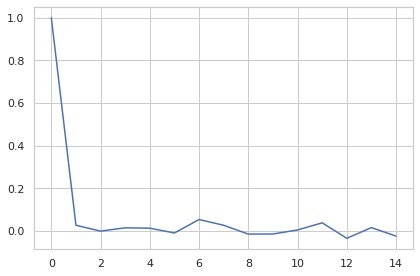

In [16]:
GG3 = FF3Traittest(return_adj, market_cap, ep_ratio)
# selfCorr = [np.mean([np.mean([GG3.iloc[j*252:(j+1)*252,k].corr(GG3.iloc[j*252:(j+1)*252,k].shift(i)) for k in range(GG3.shape[1])]) for j in range(GG3.shape[0]//252-1)]) for i in range(15)]
selfCorr = [np.mean([GG3.iloc[j*252:(j+1)*252].corr(GG3.iloc[j*252:(j+1)*252].shift(i)) for j in range(GG3.shape[0]//252-1)]) for i in range(15)]

plt.plot(selfCorr)


从特异收益率的自相关来看，periods=252时，lag=6是个不错的NW调整参数

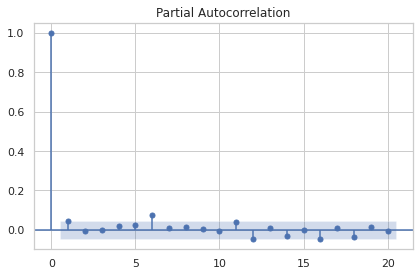

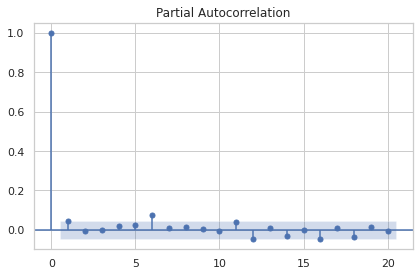

In [19]:
plot_pacf(GG3, lags=20)

In [346]:
FF3traitvol = FF3Trait(return_adj, market_cap, ep_ratio)

In [347]:
FF3traitvol

stock_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,688687.SH,688689.SH,688696.SH,688698.SH,688699.SH,688777.SH,688788.SH,688819.SH,688981.SH,689009.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,0.019801,0.016976,NaN,0.013478,0.011707,0.036539,NaN,0.024006,0.032246,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023502,NaN
2021-10-26,0.019790,0.017140,NaN,0.013476,0.011724,0.036778,NaN,0.024006,0.032243,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023503,NaN
2021-10-27,0.019798,0.017162,NaN,0.012024,0.011714,0.036776,NaN,0.023671,0.032217,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023496,NaN


In [361]:
MaxRet_6, MinRet_6 = MaMaxMinRett(return_adj, 63, 6)
factor_vol = stdvol(close, 126)
factor_mag = spread(close, 126)

In [ ]:
sns.kdeplot(factor_mag.iloc[-3,:])

单因子截面回归显著性、平稳性检验流程：
1. 单因子截面回归，获得每个时刻因子的收益值
2. 对于单因子的收益率时序数据分时间段统计（每年与每季度），平稳性检验
3. 构造时序数据的t统计量，检验因子收益在这段时间内不为0的假设

多因子逐步截面回归：
囊括不同的因子对超额收益做截面回归，得到不同因子的收益率序列


Fama-MacBeth Test:
https://www.zhihu.com/question/53768802/answer/460969682
1. 已知因子的时序收益和股票的时序超额收益，多元回归得到beta作为各个因子的暴露
滑动窗口就会得到时序序列，如果统一做了一次回归，只会得到一次beta
2. 对每个时间的因子暴露作截面回归，
3. 

In [ ]:
def facStaCoef(factorExposure, periods):
    t = [[factorExposure.iloc[i:i+periods,:].mean(axis=0)] for i in range(0, factorExposure.shape[0], periods)]
    res = 0
    for i in range(1,len(t)):
        res = res+t[i].corr(t[i-1]) #pearson corr
        res = res+rank(t[i]).corr(rank(t[i-1])) # spearman corr
    res = res/(len(t)-1) # better greater than 0.9
    return res 


平稳性检验：
1. 可视化，将每个时期的收益barplot（hist）
2. 单位根检验, ADF检验，KPSS检验，希望给出相同的结论
https://blog.csdn.net/zhouxuechao/article/details/118441111

from arch.unitroot import ADF

adf = ADF(y)
print(adf.summary().as_text())

adf.trend = 'ct'
print(adf.summary().as_text())

trend:
'n':无截距与时间趋势
'c': 有截距
'ct': 有截距，有时间趋势
'ctt': 有截距，有时间趋势，由二次型时间趋势

In [241]:
def NeweyWest(factors, W, q):
    
    # 协方差矩阵的NW调整
    # 当考虑长周期的协方差矩阵时，周期越长，相邻数据所包含的信息重合度越高，自相关性越强
    # 此时需要对日频数据做NW调整，从而得到更好的长周期协方差矩阵
    # 调整后的日频协方差阵*N就是N日的协方差矩阵
    # N=22 代表月频协方差矩阵
    # https://zhuanlan.zhihu.com/p/38506157
    
    # factors: row:date column:factor
    periods = W.shape[0]
    # print(periods)
    # print(W)
    W = np.sqrt(W) # 直接对factors做更改
    factors = W*factors
    V = factors.T.dot(factors)/(periods-1)
    for i in range(q):
        weight = 1-(i+1)/(1+q)
        ad = weight*(factors.T[:,i+1:].dot(factors[:periods-i-1,:]))/(periods-1)
        V = V+ad+ad.T
    
    return V
    
    
def EstiCovMatrix(factors, T=504, T_halflife=84, q=2):
    # 当序列为q阶移动自相关序列MA(q)时，采用T半衰期加权计算协方差，rolling(2T)
    
    # factors面板，列名因子，行名时间
    res = {}
    if T<factors.shape[1]:
        print('Warning: In principle, the periods should larger than number of factors!')
    
    weight = (2*T_halflife-1)/(2*T_halflife) # 半衰期对应底数 weight**T_halflife = 0.5
    
    W = np.diag([weight**(T-i) for i in range(T)]) # 越靠下权重越大
    W_total = np.diag(W).sum()
    W = W/W_total # 权重归一化
    
    print(W)
    print(np.diag(W).sum())
    
    for i in range(T, factors.shape[0]):
        s = factors.iloc[i-T:i, :].values
        V = pd.Dataframe(NeweyWest(s, W, q), index=factors.columns, columns=factors.columns)
        res[factors.index[i-1]] = V
    
    return pd.concat(res)
        
    
    

In [ ]:
EstiCovMatrix(return_adj.iloc[:,:55])

In [ ]:
# 行业因子
# 国家因子作为截距项，同行业因子具有完全共线性，不额外添加





In [362]:
'''
市值因子
'''
def size(market_cap):
    market_cap = market_cap.apply(np.log)
    market_cap = standardize(BarraEUE3(market_cap))
    return market_cap

'''
非线性市值
市值中性化
'''
def nlsize(market_cap):
    X = market_cap.apply(np.log)
    nlmc = (X**3)
    beta = ((nlmc*X).sum(axis=1)*nlmc.shape[1]-nlmc.sum(axis=1)*X.sum(axis=1))/(nlmc.shape[1]*(X**2).sum(axis=1)-X.sum(axis=1)**2)
    nlmc = (nlmc-X.mul(beta, axis=0)).sub(nlmc.mean(axis=1), axis=0)
    nlmc = standardize((nlmc))
    # nlmc = nlmc-X.mul((nlmc*X).sum(axis=1)/((X**2).sum(axis=1)), axis=0)
    
    return nlmc

lgsize = size(market_cap)
cubsize = nlsize(market_cap)

In [366]:
lgsize

stock_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,688687.SH,688689.SH,688696.SH,688698.SH,688699.SH,688777.SH,688788.SH,688819.SH,688981.SH,689009.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,3.151603,3.090016,-1.651654,0.347740,-0.580369,0.965212,-0.046420,-0.015951,1.346604,-0.869993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,3.148506,3.080929,-1.649950,0.322988,-0.581774,0.943893,-0.032764,-0.035119,1.337477,-0.883633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,3.150849,3.058839,-1.573681,0.291204,-0.603803,0.964381,-0.078316,-0.043864,1.305770,-0.900098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.149339,3.048555,-1.588769,0.282144,-0.626658,0.956211,-0.082533,-0.049532,1.294761,-0.902834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,3.178562,3.041835,-1.592391,0.263474,-0.651016,0.932784,-0.066419,-0.076950,1.287283,-0.914348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,3.144470,2.962351,-0.863998,-0.273888,-0.206582,1.609644,-0.812890,-0.119048,1.119600,-1.505621,...,-0.649316,-0.631555,0.980651,-0.641210,0.726432,1.436307,0.168026,1.495835,3.171592,1.577946
2021-10-26,3.142662,2.922834,-0.910116,-0.278243,-0.195194,1.665412,-0.801249,-0.126848,1.123645,-1.500829,...,-0.640902,-0.613219,0.948704,-0.644207,0.655129,1.454144,0.159199,1.485293,3.168615,1.553004
2021-10-27,3.141052,2.921021,-0.951599,-0.278524,-0.194807,1.671441,-0.744886,-0.128952,1.109772,-1.497696,...,-0.659601,-0.639041,0.966183,-0.599709,0.630239,1.426906,0.244222,1.454928,3.164975,1.508660


In [12]:
# OLS截面回归特质波动率和市值倒数，市值开方倒数分别scatter
# 看两种情况哪种相关性更强

In [393]:
# 单因子测试
# https://www.joinquant.com/view/community/detail/f3096c96ddcf67d49126f23018821f48?type=1

W = 1/market_cap

# 选用市值倒数作为权重，改善不同市值股票之间显著的异方差性
# 此处基于 市值倒数和特质波动率的负相关性



def SingleFactorReg_cs(return_adj, factor, W, ):
    # 收益率关于单因子的截面加权回归，得到单因子收益率时间序列
    # 加入截距项可以得到无偏估计，对于bias的解释就是factor并不能解释所有的收益来源
    
    # 因子收益序列t值绝对值均值，
    # 每一期截面回归都会有t值，代表当期的收益和因子是否有显著相关性，或者说回归值是否显著不为0
    # 由于可能正负关系随时间也是不定的，所以直接均值会导致抵消，尤其是风险因子！
    
    # t绝对值大于2的比例（判断t值的平稳性）
    
    W = W.where(return_adj.notna()&factor.notna())
    W = W.div(W.sum(axis=1), axis=0)
    columns = ['slope', 'tvalue', 'pvalue']
    df_raw = {}
    for row in return_adj.index:
        if W.loc[row,:].isna().all():
            df_raw[row] = np.nan
            continue
        res = WLS(return_adj.loc[row,:].T, sm.add_constant(factor.loc[row, :].T), W.loc[row,:].T, missing='drop').fit()
        df_raw[row] = pd.Series([res.params.iloc[1], res.tvalues.iloc[1], res.pvalues.iloc[1]], index = columns)
        
    return pd.DataFrame(df_raw).T
    
    # return_factor = ((factor*W*(return_adj.sub(return_adj.mean(axis=1),axis=0))).sum(axis=1))/((factor*W*(factor.sub(factor.mean(axis=1), axis=0))).sum(axis=1))
    # return_factor = ((factor*W*return_adj).sum(axis=1))/((factor*W*factor).sum(axis=1))
    # t_stat = return_factor.abs().mean()/return_factor.abs().std()
    
    # return return_factor, t_stat
    
    
def SingleFactorIC(return_adj, factor):
    #IC值为T期因子暴露与T+1期收益率相关系数，截面上每个时间都会有一个因子IC值，
    
    # IC序列均值，绝对值均值
    # IC序列标准差
    # IC序列单边比例
    res = {}
    
    return_adj.shift(-1, inplace=True)
    for row in return_adj.index:
        res[row] = return_adj.loc[row,:].corr(factor.loc[row,:], method='spearman')
        
    return pd.Series(res)

二级因子：

市值因子：lgsize

非线性市值：cubsize

趋势因子： T120，T240

流动性因子： meanturnover，lgbeta

波动率因子：MaxRet_6, MinRet_6, factor_vol, factor_mag FF3特质波动（..）

每只股票的全市场基准的Beta：RetBeta

Beta因子： shBeta

价值因子： bp，ep

soe： soe

成长因子： roe_diff， sales_grow， netAsset_grow

未分类因子： InstHoldPct，Cov，Listdays

一级因子：

Trend

Liquidity

volatility

ShBeta

In [372]:
ret_lgsize = SingleFactorReg_cs(return_adj, lgsize, W)
# ret_shBeta, t_shBeta = SingleFactorReg_cs(return_adj, shBeta, W)

<AxesSubplot:title={'center':'lg_size'}>

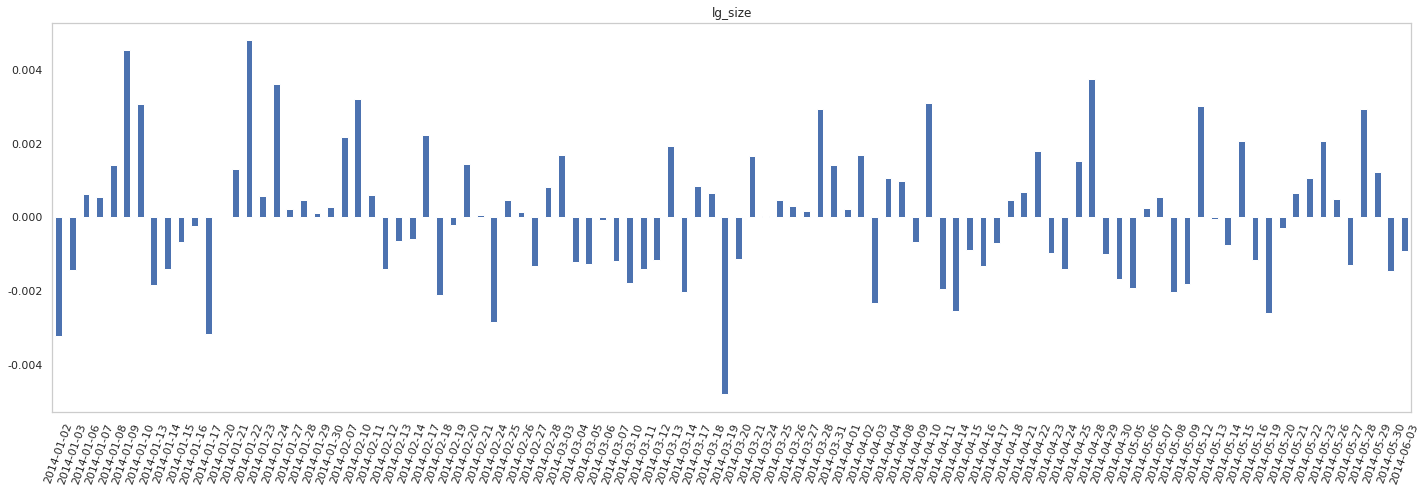

In [386]:
fig, ax = plt.subplots(figsize=(20,7))
ret_lgsize.slope[:100].plot(kind='bar', grid=False, rot=70, title='lg_size', legend=False)

In [389]:
(ret_lgsize.tvalue.abs()>2).sum()/ret_lgsize.shape[0]

0.6787401574803149

In [394]:
ret_shbeta = SingleFactorReg_cs(return_adj, shBeta, W)

<AxesSubplot:title={'center':'shbeta'}>

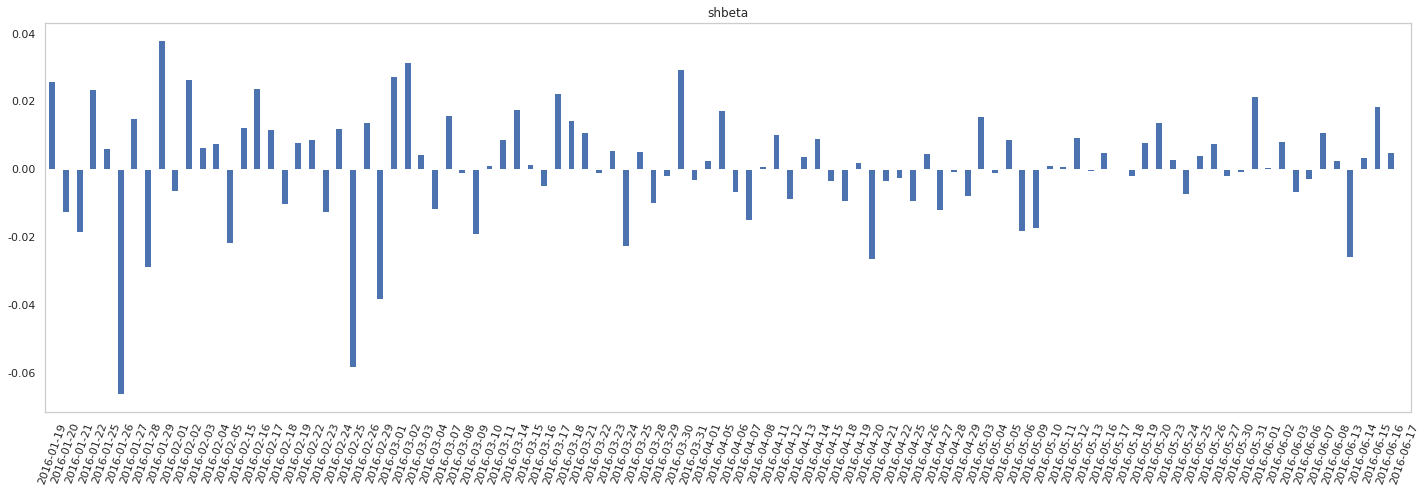

In [396]:
fig, ax = plt.subplots(figsize=(20,7))
ret_shbeta.slope[500:600].plot(kind='bar', grid=False, rot=70, title='shbeta', legend=False)

count    1654.000000
mean        0.534716
std         8.650764
min       -32.969062
25%        -4.255944
50%         0.355978
75%         5.399220
max        35.445326
Name: tvalue, dtype: float64
6.418602477704093
5.822236264562366
0.6614173228346457


In [418]:
def SingleFactorDescribe(ret, title, freq='d',):
    print('============因子收益t-stats===========================')
    print('\n因子收益显著性时序统计:')
    print(ret.tvalue.describe())
    print('\n绝对值统计：')
    print(ret.tvalue.abs().describe())
    print('\n|t|>2 比例：')
    print((ret.tvalue.abs()>2).sum()/ret.tvalue.notna().sum())
    
    print('\n\n================因子收益===========================')
    fig, ax = plt.subplots(figsize=(20,7))
    # xticks = list(ret.index[::ret.shape[0]//10])
    ((ret.slope+1).cumprod()-1).plot(kind='line', ax=ax, grid=False, rot=50, title=f'ret of {title}', legend=False)
    
    return True
    
    

============因子收益t-stats===========================

因子收益显著性时序统计:
count    1654.000000
mean        0.534716
std         8.650764
min       -32.969062
25%        -4.255944
50%         0.355978
75%         5.399220
max        35.445326
Name: tvalue, dtype: float64

绝对值统计：
count    1654.000000
mean        6.418602
std         5.822236
min         0.004255
25%         2.112610
50%         4.783570
75%         8.918354
max        35.445326
Name: tvalue, dtype: float64

|t|>2 比例：
0.7617896009673518


================因子收益===========================


True

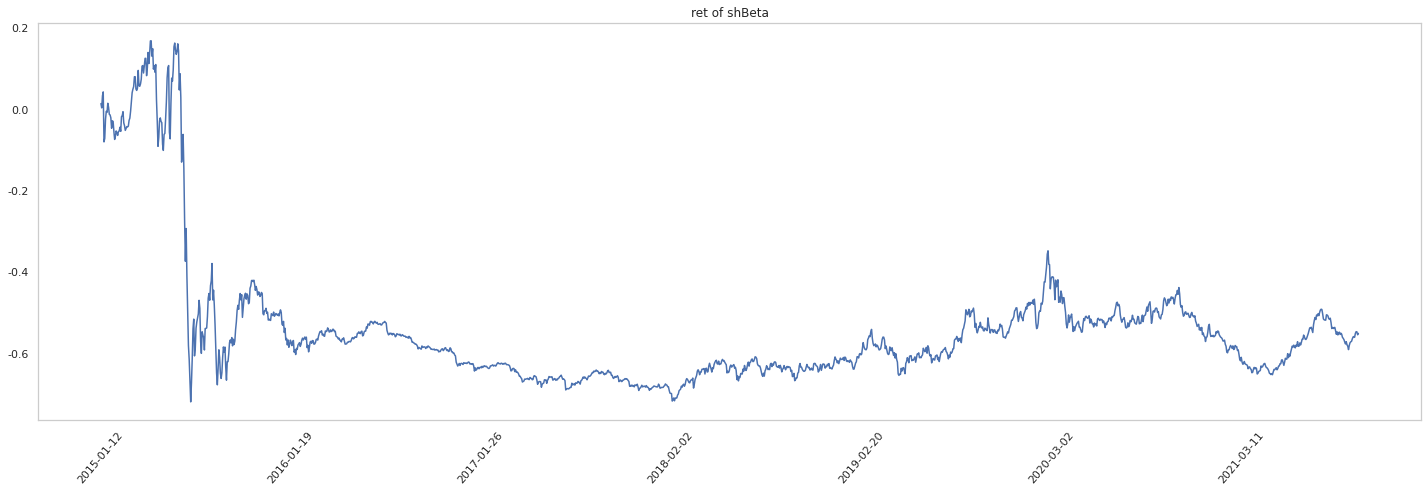

In [419]:
SingleFactorDescribe(ret_shbeta, 'shBeta')

低频度的因子收益
和高频度因子收益的和
是否是显著不同的？

按照低频数据作回归，求低频的因子收益率，和高频的求和相比较。
检验两个序列显著不同的假设是否成立？

要如何解释？
背后是否有什么市场规律的解释或者模型背后的解释？

Y=a+bx
原假设a\neq0 b\neq1
Y-x = a+(b-1)x
回归F检验的显著性

In [15]:
# 方差膨胀因子VIF>5 存在严重的共线性问题，应该考虑舍弃

def VIF(factor, factors:list):
    '''
    用factors对factor做回归
    vif = 1/(1-r^2)
    '''
    pass
    

In [17]:
temp_lgsize = pd.DataFrame(ret_lgsize)
temp_lgsize['year'] = [tuple(x.split('-')[:1]) for x in temp_lgsize.index]
temp_lgsize = temp_lgsize.groupby('year', as_index=True).sum()

<AxesSubplot:title={'center':'lg_size'}, xlabel='year'>

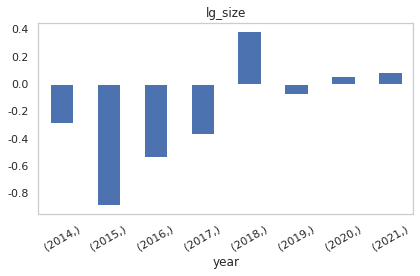

In [19]:
temp_lgsize.plot(kind='bar', grid=False, rot=30, title='lg_size', legend=False)

In [ ]:
temp_lgsize

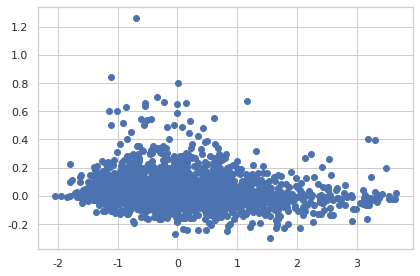

In [221]:

return_adj['year'] = [tuple(x.split('-')[:2]) for x in return_adj.index]
lgsize['year'] = [tuple(x.split('-')[:2]) for x in lgsize.index]

r_month = return_adj.groupby('year', as_index=True).sum()
r_cap = lgsize.groupby('year', as_index=True).mean()

plt.scatter(r_cap.iloc[1,:], r_month.iloc[1,:])

return_adj.drop('year', axis=1, inplace=True)
lgsize.drop('year', axis=1, inplace=True)

协方差矩阵的特征值调整：
https://zhuanlan.zhihu.com/p/82047494
1. 对已经得到的协方差矩阵对角化 D = U'VU
2. 采样作为因子收益，第k个因子的总体分布是N(0,D(k))
3. 得到了因子收益序列，求仿真的协方差矩阵，Vm，m表示第m次仿真
4. 对角化Vm：Dm=U'mVmUm
5. Dm2 = U'mVUm 
6. lambdak = (sqrt(Dm2(k,k)/Dm(k,k))).mean()

7. 标度变换：gammak = a(lambdak-1)+1, a=1.4是个不错的选择
8. gamma = diag(gammak)
9. D_ad = gamma^2*D
10. V_ad = U*D_ad*U' 即为特征值调整的协方差矩阵

TIP. 特征值调整基于会低估小方差组合方差，高估大方差组合方差，
或者说方差会有一个回归的趋势，需要在估计时，加入一个关于这个回归的调整。
